# Spam vs Ham Email Classification using NLP

This project focuses on building a machine learning model to classify emails as **spam** or **ham** (non-spam).  
We explore and compare different word vectorization techniques including:

- Bag of Words (BoW)
- TF-IDF (Term Frequency-Inverse Document Frequency)
- Word2Vec trained from scratch on the dataset

The goal is to understand the impact of each vectorization method on classification accuracy and model performance.


Downloading necessary libraries for data manipulation, preprocessing, visualization, and modeling


In [1]:
!pip install "numpy<2.0" --force-reinstall
!pip install --upgrade --force-reinstall gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 770.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 40.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 14.2 MB/s eta 0:00:00
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 8.6 MB/s et

In [1]:
!pip install nltk

In [2]:
!pip install tqdm

In [3]:
# Importing necessary libraries for data manipulation, preprocessing, visualization, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from gensim.models import Word2Vec, KeyedVectors
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import re

## Dataset Description

The dataset consists of labeled emails categorized into 'spam' and 'ham'.  
Each sample contains the email text and its corresponding label.

In [4]:
import pandas as pd
import numpy as np
messages=pd.read_csv('SMSSpamCollection',
                    sep='\t',names=["label","message"])

In [5]:
messages

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


##Exploratory Data Analysis

In [6]:
print("Dataset shape:", messages.shape)
print("Columns:", messages.columns)
print("Missing values in each column:\n", messages.isnull().sum())
print("Number of duplicate rows:", messages.duplicated().sum())

Dataset shape: (5572, 2)
Columns: Index(['label', 'message'], dtype='object')
Missing values in each column:
 label      0
message    0
dtype: int64
Number of duplicate rows: 403


In [7]:
messages.drop_duplicates(inplace=True)
print("Dataset shape:", messages.shape)
print("Number of duplicate rows:", messages.duplicated().sum())

Dataset shape: (5169, 2)
Number of duplicate rows: 0


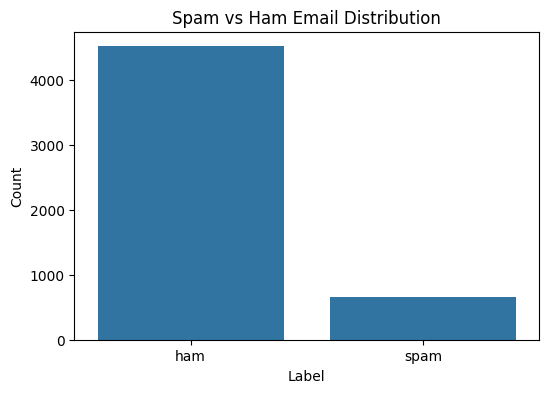

In [8]:
#Label Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=messages)
plt.title('Spam vs Ham Email Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

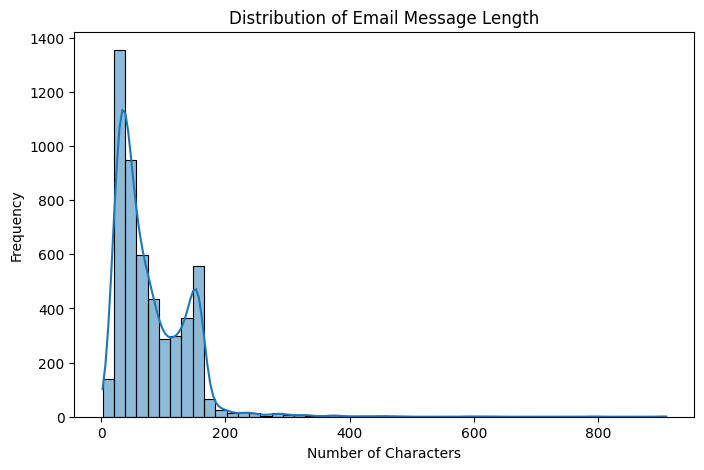

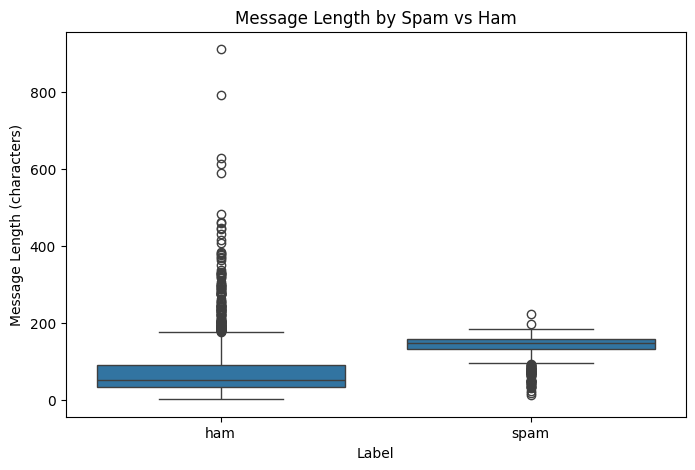

In [9]:
#Text Length Analysis
length_df = messages.copy()

length_df['text_length'] = length_df['message'].apply(len)

# Plot distribution of text length overall
plt.figure(figsize=(8,5))
sns.histplot(length_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Email Message Length')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Boxplot to compare text length by label
plt.figure(figsize=(8,5))
sns.boxplot(x='label', y='text_length', data=length_df)
plt.title('Message Length by Spam vs Ham')
plt.xlabel('Label')
plt.ylabel('Message Length (characters)')
plt.show()

##Train-Test Split

In [10]:
X = messages['message']
y = messages['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
messages_train = pd.DataFrame({
    'label': y_train,
    'message': X_train
})

messages_test = pd.DataFrame({
    'label': y_test,
    'message': X_test
})

## Data Cleaning And Preprocessing

In [12]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [13]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [14]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [15]:
def preprocessor(messages):
    corpus = []
    for i in range(len(messages)):
        text = messages['message'].iloc[i]
        text = re.sub('[^a-zA-Z]', ' ', text)          # Remove non-letters
        text = text.lower()                            # Lowercase
        tokens = word_tokenize(text)                   # Tokenize
        filtered_tokens = [w for w in tokens if w not in stop_words]  # Remove stopwords
        pos_tags = pos_tag(filtered_tokens)            # POS tagging
        lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]  # Lemmatize
        corpus.append(' '.join(lemmatized_tokens))  # Join back to string
    return corpus

In [16]:
corpus_train = preprocessor(messages_train)

## Create Bag Of Words

In [17]:
cv=CountVectorizer(max_features=2500,ngram_range=(1,2))

In [18]:
## independent features
X_train_bow = cv.fit_transform(corpus_train).toarray()

In [19]:
cv.vocabulary_

{'oh': 1457,
 'take': 2015,
 'test': 2058,
 'one': 1483,
 'get': 774,
 'home': 946,
 'get home': 783,
 'hey': 917,
 'next': 1416,
 'sun': 1986,
 'basic': 127,
 'yoga': 2493,
 'course': 449,
 'bugis': 207,
 'go': 811,
 'intro': 1023,
 'sat': 1782,
 'tell': 2044,
 'time': 2123,
 'free': 735,
 'vote': 2324,
 'wherever': 2407,
 'heart': 911,
 'guide': 880,
 'ok': 1463,
 'try': 2192,
 'week': 2386,
 'end': 633,
 'see': 1806,
 'cup': 465,
 'coffee': 365,
 'hi': 922,
 'amp': 52,
 'mom': 1348,
 'car': 273,
 'park': 1521,
 'long': 1206,
 'story': 1966,
 'car park': 274,
 'need': 1399,
 'detail': 533,
 'online': 1486,
 'job': 1054,
 'dear': 510,
 'final': 703,
 'notice': 1441,
 'collect': 369,
 'tenerife': 2053,
 'holiday': 942,
 'cash': 284,
 'award': 105,
 'call': 226,
 'landline': 1107,
 'tc': 2031,
 'sae': 1776,
 'box': 182,
 'cw': 478,
 'wx': 2463,
 'ppm': 1633,
 'tenerife holiday': 2054,
 'holiday cash': 944,
 'cash award': 286,
 'award call': 107,
 'call landline': 240,
 'sae box': 1777,


In [20]:
#One Hot Encoding output features
y_train_bow = messages_train['label'].map({'ham': 0, 'spam': 1})

In [21]:
y_train_bow.shape

(4135,)

In [22]:
X_train_bow.shape

(4135, 2500)

In [23]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model=MultinomialNB().fit(X_train_bow,y_train_bow)

In [24]:
corpus_test = preprocessor(messages_test)

X_test_bow = cv.transform(corpus_test).toarray()
y_test_bow = messages_test['label'].map({'ham': 0, 'spam': 1})

y_pred_bow = spam_detect_model.predict(X_test_bow)


In [25]:
from sklearn.metrics import accuracy_score,classification_report

In [26]:
accuracy_score(y_test_bow,y_pred_bow)

0.97678916827853

In [27]:
print(classification_report(y_test_bow,y_pred_bow))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       894
           1       0.93      0.90      0.91       140

    accuracy                           0.98      1034
   macro avg       0.96      0.94      0.95      1034
weighted avg       0.98      0.98      0.98      1034



## Using TF-IDF model

In [28]:
tv = TfidfVectorizer(max_features=2500,ngram_range=(1,2))
X_train_tfidf = tv.fit_transform(corpus_train).toarray()
y_train_tfidf = messages_train['label'].map({'ham': 0, 'spam': 1})

In [29]:
X_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
tv.vocabulary_

{'oh': 1457,
 'take': 2015,
 'test': 2058,
 'one': 1483,
 'get': 774,
 'home': 946,
 'get home': 783,
 'hey': 917,
 'next': 1416,
 'sun': 1986,
 'basic': 127,
 'yoga': 2493,
 'course': 449,
 'bugis': 207,
 'go': 811,
 'intro': 1023,
 'sat': 1782,
 'tell': 2044,
 'time': 2123,
 'free': 735,
 'vote': 2324,
 'wherever': 2407,
 'heart': 911,
 'guide': 880,
 'ok': 1463,
 'try': 2192,
 'week': 2386,
 'end': 633,
 'see': 1806,
 'cup': 465,
 'coffee': 365,
 'hi': 922,
 'amp': 52,
 'mom': 1348,
 'car': 273,
 'park': 1521,
 'long': 1206,
 'story': 1966,
 'car park': 274,
 'need': 1399,
 'detail': 533,
 'online': 1486,
 'job': 1054,
 'dear': 510,
 'final': 703,
 'notice': 1441,
 'collect': 369,
 'tenerife': 2053,
 'holiday': 942,
 'cash': 284,
 'award': 105,
 'call': 226,
 'landline': 1107,
 'tc': 2031,
 'sae': 1776,
 'box': 182,
 'cw': 478,
 'wx': 2463,
 'ppm': 1633,
 'tenerife holiday': 2054,
 'holiday cash': 944,
 'cash award': 286,
 'award call': 107,
 'call landline': 240,
 'sae box': 1777,


In [31]:
from sklearn.naive_bayes import MultinomialNB

In [32]:
spam_detect_model=MultinomialNB().fit(X_train_tfidf,y_train_tfidf)

In [33]:
corpus_test = preprocessor(messages_test)

X_test_tfidf = tv.transform(corpus_test).toarray()
y_test_tfidf = messages_test['label'].map({'ham': 0, 'spam': 1})

y_pred_tfidf = spam_detect_model.predict(X_test_tfidf)

In [34]:
from sklearn.metrics import accuracy_score,classification_report

In [35]:
accuracy_score(y_test_tfidf,y_pred_tfidf)

0.9729206963249516

In [36]:
print(classification_report(y_test_tfidf,y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       894
           1       0.98      0.81      0.89       140

    accuracy                           0.97      1034
   macro avg       0.98      0.91      0.94      1034
weighted avg       0.97      0.97      0.97      1034



## WORD2VEC from scratch

In [37]:
tokenized_corpus_train = [word_tokenize(text) for text in corpus_train]
tokenized_corpus_test = [word_tokenize(text) for text in corpus_test]

In [38]:
model = gensim.models.Word2Vec(tokenized_corpus_train, min_count=1, workers=4)

In [39]:
def avg_word2vec(doc):
    # remove out-of-vocabulary words
    words = [word for word in doc if word in model.wv.index_to_key]
    if not words:
        return np.zeros(model.vector_size) # Use model.vector_size for the dimension
    return np.mean([model.wv[word] for word in words], axis=0)


In [40]:
X_train_w2v = np.array([avg_word2vec(doc) for doc in tqdm(tokenized_corpus_train)])
X_test_w2v = np.array([avg_word2vec(doc) for doc in tqdm(tokenized_corpus_test)])

y_train_w2v = messages_train['label'].map({'ham': 0, 'spam': 1})
y_test_w2v = messages_test['label'].map({'ham': 0, 'spam': 1})

100%|██████████| 1034/1034 [00:00<00:00, 3462.41it/s]


##### Hyperparameter Tuning with GridSearchCV

In [41]:
# Define models and parameter grids
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l2']
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20]
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    }
}

In [42]:
best_model = None
best_accuracy = 0
best_model_name = ""

for model_name, mp in models.items():
    print(f"Tuning {model_name}...")
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train_w2v, y_train_w2v)

    print(f"Best parameters for {model_name}: {clf.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {clf.best_score_}")

    y_pred = clf.predict(X_test_w2v)
    accuracy = accuracy_score(y_test_w2v, y_pred)
    print(f"Test accuracy for {model_name}: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = clf.best_estimator_


Tuning LogisticRegression...
Best parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
Best cross-validation accuracy for LogisticRegression: 0.8759371221281741
Test accuracy for LogisticRegression: 0.8646034816247582
Tuning RandomForestClassifier...
Best parameters for RandomForestClassifier: {'max_depth': None, 'n_estimators': 200}
Best cross-validation accuracy for RandomForestClassifier: 0.9371221281741233
Test accuracy for RandomForestClassifier: 0.9342359767891683
Tuning SVC...
Best parameters for SVC: {'C': 0.1, 'kernel': 'linear'}
Best cross-validation accuracy for SVC: 0.8759371221281741
Test accuracy for SVC: 0.8646034816247582


In [43]:
best_model_name = model_name

print("\n--- Best Model Results ---")
print(f"Best model: {best_model_name}")
y_pred_best = best_model.predict(X_test_w2v)
print(f"Accuracy: {accuracy_score(y_test_w2v, y_pred_best)}")
print("Classification Report:")
print(classification_report(y_test_w2v, y_pred_best))


--- Best Model Results ---
Best model: SVC
Accuracy: 0.9342359767891683
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       894
           1       0.94      0.55      0.69       140

    accuracy                           0.93      1034
   macro avg       0.94      0.77      0.83      1034
weighted avg       0.93      0.93      0.93      1034

